In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/My\ Drive/EOE

Mounted at /content/gdrive
/content/gdrive/My Drive/EOE


In [ ]:
import pandas as pd
from PIL import Image
import torch
from torchvision import models
from torch import nn
import os
from torch.utils.data import TensorDataset, DataLoader
import numpy as np 
import torchvision
from tqdm import tqdm

In [ ]:
labels_df = pd.read_excel('./labels.xlsx', header=None)  # Read excel label file
labels_df=labels_df.dropna()
labels_df.head()

,0,1
0,1,0
1,2,0
2,3,0
3,4,1
4,5,0


In [ ]:
idx2y = {}
for i in range(len(labels_df)):
    idx2y[int(labels_df.iloc[i, 0])] = int(labels_df.iloc[i, 1])  # Match the number to the category one by one

In [ ]:
normalize = torchvision.transforms.Normalize(
   mean=[0.5,0.5,0.5], std=[0.5, 0.5, 0.5])  # Normalize images

train_augs = torchvision.transforms.Compose([
    torchvision.transforms.Resize((256, 256)),
    torchvision.transforms.ToTensor(),
    normalize])  

test_augs = torchvision.transforms.Compose([
    torchvision.transforms.Resize((256, 256)),
    torchvision.transforms.ToTensor(),
    normalize
])  

In [ ]:
def load_data(train_ratio=0.7, test_ratio=0.15, expand_ratio=2):  # expand_ratio is the multiple of image augmentation
    # The function that reads the data set, and finally returns three DataLoaders, which are the training set, the test set and the validation set
    labels = []
    temps = []
    for root, dirs, files in os.walk('./EOEHSS_Image'):
        for file in files:
            path = os.path.join(root, file)
            idx = int(file.split('_')[0])
            if idx in idx2y:
                for i in range(expand_ratio):
                    labels.append(idx2y[idx])
                    temps.append(Image.open(path))  # Read image
    np.random.seed(7)
    np.random.shuffle(labels)
    np.random.seed(7)
    np.random.shuffle(temps)  # Shuffle data

    train_size = int(train_ratio * len(labels))
    test_size = int(test_ratio * len(labels))
    valid_size = len(labels) - train_size - test_size
    train_images = temps[:train_size]
    train_labels = labels[:train_size]
    test_images = temps[train_size: train_size + test_size]
    test_labels = labels[train_size: train_size + test_size]
    valid_images = temps[train_size + test_size:]
    valid_labels = labels[train_size + test_size:]  # Divide training set, test set and validation set

    for i in range(len(train_images)):
        train_images[i] = np.array(train_augs(train_images[i]))
    for i in range(len(test_images)):
        test_images[i] = np.array(test_augs(test_images[i]))
    for i in range(len(valid_images)):
        valid_images[i] = np.array(test_augs(valid_images[i]))  # numpy array

    train_labels = torch.tensor(train_labels, dtype=torch.int64)
    train_images = torch.tensor(train_images, dtype=torch.float32)
    test_labels = torch.tensor(test_labels, dtype=torch.int64)
    test_images = torch.tensor(test_images, dtype=torch.float32)
    valid_labels = torch.tensor(valid_labels, dtype=torch.int64)
    valid_images = torch.tensor(valid_images, dtype=torch.float32)  # torch tensor

    train_dataset = TensorDataset(train_images, train_labels)
    test_dataset = TensorDataset(test_images, test_labels)
    valid_dataset = TensorDataset(valid_images, valid_labels)  # TensorDataset

    train_loader = DataLoader(train_dataset, batch_size=8)
    test_loader = DataLoader(test_dataset, batch_size=8)
    valid_loader = DataLoader(valid_dataset, batch_size=8)  # DataLoader

    return train_loader, test_loader, valid_loader

In [ ]:
train_loader, test_loader, valid_loader = load_data()  # Read data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)


In [ ]:
for X, y in train_loader:
    print(X.shape, y.shape)
    break

torch.Size([8, 3, 256, 256]) torch.Size([8])


In [ ]:
num_classes = 2  
densenet = models.densenet121(pretrained=True)  
densenet.grad_ = False  
densenet.classifier = nn.Linear(1024, num_classes)  

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

In [ ]:
def evaluate(net, valid_iter, device):
    net.to(device)
    net.eval()
    num_valid_samples = 0
    num_acc = 0
    for X, y in valid_iter:
        X, y = X.to(device), y.to(device)
        y_hat = net(X)
        y_pred = y_hat.argmax(dim=-1)
        num_valid_samples += len(X)
        num_acc += torch.sum(y_pred == y)
    return float(num_acc) / num_valid_samples

In [ ]:
def train(net, train_iter, test_iter, valid_iter, num_epochs, lr, device):
    print("training on", device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    train_loss_list = []
    train_acc_list = []
    valid_acc_list = []
    test_acc_list = []
    for epoch in tqdm(range(num_epochs)):
        net.train()
        num_train = 0
        train_acc = 0
        train_loss = 0
        for i, (X, y) in enumerate(train_iter):
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            num_train += len(X)
            train_acc += torch.sum(y_hat.argmax(dim=-1) == y)
            train_loss += l.item() * len(X)
        train_loss = float(train_loss) / num_train
        train_acc = float(train_acc) / num_train
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        net.eval()
        num_test = 0
        test_acc = 0
        for X, y in test_iter:
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            num_test += len(X)
            test_acc += torch.sum(y_hat.argmax(dim=-1) == y)
        test_acc = float(test_acc) / num_test
        test_acc_list.append(test_acc)
        valid_acc = evaluate(net, valid_iter, device)
        valid_acc_list.append(valid_acc)
        if (epoch + 1) % 10 == 0:
            print('train loss:', train_loss_list, 'train acc:', train_acc_list, 'test acc:', test_acc_list,
                  'valid acc:', valid_acc_list)

    return train_loss_list, train_acc_list, test_acc_list, valid_acc_list

In [ ]:
device = torch.device ( "cuda")
num_epochs = 50
lr = 1e-2

train_loss_list, train_acc_list, test_acc_list, valid_acc_list = train(densenet, train_loader, test_loader, valid_loader, num_epochs, lr, device)

training on cuda


 20%|██        | 10/50 [01:55<06:54, 10.37s/it]

train loss: [0.5771590328884282, 0.26542935553551505, 0.12610451302673711, 0.08974571452710833, 0.14525005225049212, 0.09398768366586042, 0.023960209283609514, 0.00791823618878078, 0.0032370307337403715, 0.0018658117859898966] train acc: [0.7215815485996705, 0.8912685337726524, 0.9522240527182867, 0.9686985172981878, 0.943986820428336, 0.9621087314662273, 0.9967051070840197, 1.0, 1.0, 1.0] test acc: [0.7615384615384615, 0.8153846153846154, 0.7461538461538462, 0.8615384615384616, 0.9153846153846154, 0.8769230769230769, 0.9461538461538461, 0.9384615384615385, 0.9307692307692308, 0.9307692307692308] valid acc: [0.8015267175572519, 0.8473282442748091, 0.7709923664122137, 0.8778625954198473, 0.9007633587786259, 0.916030534351145, 0.9236641221374046, 0.9236641221374046, 0.9312977099236641, 0.9312977099236641]


 40%|████      | 20/50 [03:40<05:13, 10.43s/it]

train loss: [0.5771590328884282, 0.26542935553551505, 0.12610451302673711, 0.08974571452710833, 0.14525005225049212, 0.09398768366586042, 0.023960209283609514, 0.00791823618878078, 0.0032370307337403715, 0.0018658117859898966, 0.0012682193038291627, 0.001037120624618755, 0.0008868474012342032, 0.0007781617981504459, 0.0006953311801766839, 0.000629732942805492, 0.00057620509061387, 0.000531695401384242, 0.0004940521157280691, 0.0004617182188955039] train acc: [0.7215815485996705, 0.8912685337726524, 0.9522240527182867, 0.9686985172981878, 0.943986820428336, 0.9621087314662273, 0.9967051070840197, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] test acc: [0.7615384615384615, 0.8153846153846154, 0.7461538461538462, 0.8615384615384616, 0.9153846153846154, 0.8769230769230769, 0.9461538461538461, 0.9384615384615385, 0.9307692307692308, 0.9307692307692308, 0.9307692307692308, 0.9307692307692308, 0.9307692307692308, 0.9307692307692308, 0.9307692307692308, 0.9307692307692308, 0

 60%|██████    | 30/50 [05:24<03:28, 10.44s/it]

train loss: [0.5771590328884282, 0.26542935553551505, 0.12610451302673711, 0.08974571452710833, 0.14525005225049212, 0.09398768366586042, 0.023960209283609514, 0.00791823618878078, 0.0032370307337403715, 0.0018658117859898966, 0.0012682193038291627, 0.001037120624618755, 0.0008868474012342032, 0.0007781617981504459, 0.0006953311801766839, 0.000629732942805492, 0.00057620509061387, 0.000531695401384242, 0.0004940521157280691, 0.0004617182188955039, 0.0004336175170195438, 0.0004089249797488365, 0.00038707601406099047, 0.00036762332289803413, 0.0003501547017089464, 0.00033435618757658454, 0.00032001770512105765, 0.0003069268654956355, 0.00029493067194930164, 0.0002838978647682862] train acc: [0.7215815485996705, 0.8912685337726524, 0.9522240527182867, 0.9686985172981878, 0.943986820428336, 0.9621087314662273, 0.9967051070840197, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] test acc: [0.7615384615384615, 0.81538461538461

 80%|████████  | 40/50 [07:09<01:44, 10.44s/it]

train loss: [0.5771590328884282, 0.26542935553551505, 0.12610451302673711, 0.08974571452710833, 0.14525005225049212, 0.09398768366586042, 0.023960209283609514, 0.00791823618878078, 0.0032370307337403715, 0.0018658117859898966, 0.0012682193038291627, 0.001037120624618755, 0.0008868474012342032, 0.0007781617981504459, 0.0006953311801766839, 0.000629732942805492, 0.00057620509061387, 0.000531695401384242, 0.0004940521157280691, 0.0004617182188955039, 0.0004336175170195438, 0.0004089249797488365, 0.00038707601406099047, 0.00036762332289803413, 0.0003501547017089464, 0.00033435618757658454, 0.00032001770512105765, 0.0003069268654956355, 0.00029493067194930164, 0.0002838978647682862, 0.00027369773613279024, 0.00026424251255810206, 0.00025544494999031023, 0.0002472458828832874, 0.00023958258598558052, 0.00023241017210466828, 0.00022566982215946262, 0.00021933252070980574, 0.00021335750331015124, 0.00020771082796584479] train acc: [0.7215815485996705, 0.8912685337726524, 0.9522240527182867, 0.

100%|██████████| 50/50 [08:53<00:00, 10.67s/it]

train loss: [0.5771590328884282, 0.26542935553551505, 0.12610451302673711, 0.08974571452710833, 0.14525005225049212, 0.09398768366586042, 0.023960209283609514, 0.00791823618878078, 0.0032370307337403715, 0.0018658117859898966, 0.0012682193038291627, 0.001037120624618755, 0.0008868474012342032, 0.0007781617981504459, 0.0006953311801766839, 0.000629732942805492, 0.00057620509061387, 0.000531695401384242, 0.0004940521157280691, 0.0004617182188955039, 0.0004336175170195438, 0.0004089249797488365, 0.00038707601406099047, 0.00036762332289803413, 0.0003501547017089464, 0.00033435618757658454, 0.00032001770512105765, 0.0003069268654956355, 0.00029493067194930164, 0.0002838978647682862, 0.00027369773613279024, 0.00026424251255810206, 0.00025544494999031023, 0.0002472458828832874, 0.00023958258598558052, 0.00023241017210466828, 0.00022566982215946262, 0.00021933252070980574, 0.00021335750331015124, 0.00020771082796584479, 0.00020236898228200844, 0.0001972980295381581, 0.00019248719365749111, 0.0

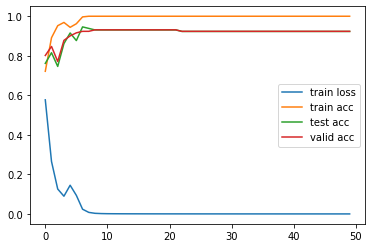

In [ ]:
from matplotlib import pyplot as plt


plt.plot(train_loss_list, label='train loss')
plt.plot(train_acc_list, label='train acc')
plt.plot(test_acc_list, label='test acc')
plt.plot(valid_acc_list, label='valid acc')
plt.legend()
plt.show()

In [ ]:
print(max(test_acc_list))

0.9461538461538461
